In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV 

import sys
from contextlib import redirect_stdout


import copy
import matplotlib.pyplot as plt
import tqdm
import joblib

import torch
import torch.nn as nn
import torch.optim as optim

In [18]:
# Read the data from the files
X_train_raw = pd.read_csv('dataset/X_train.tsv', sep='\t')
X_test_raw = pd.read_csv('dataset/X_test.tsv', sep='\t')
y_train = pd.read_csv('dataset/y_train.tsv', sep='\t')
y_test = pd.read_csv('dataset/y_test.tsv', sep='\t')

In [52]:
# Standardizing data
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [53]:
X_train = torch.tensor(X_train_raw.values, dtype=torch.float32)
X_test = torch.tensor(X_test_raw.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

In [21]:
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

C:\Users\cgonz\AppData\Local\Temp\ipykernel_7196\3776398501.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
C:\Users\cgonz\AppData\Local\Temp\ipykernel_7196\3776398501.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)


ValueError: could not determine the shape of object type 'DataFrame'

In [36]:
input_size = X_train.shape[1]

# Create a simple nn with 180 input values
model = nn.Sequential(
    nn.Linear(input_size, 120),
    nn.ReLU(),
    nn.Linear(120, 60),
    nn.ReLU(),
    nn.Linear(60, 30),
    nn.ReLU(),
    nn.Linear(30, 18),
    nn.ReLU(),
    nn.Linear(18, 8),
    nn.ReLU(),
    nn.Linear(8, 1)
)

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# training parameters
n_epochs = 100   # number of epochs to run
batch_size = 50  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

Epoch 0 MSE: 0.596193253993988
Epoch 1 MSE: 0.4895417094230652
Epoch 2 MSE: 0.40776485204696655
Epoch 3 MSE: 0.35822027921676636
Epoch 4 MSE: 0.3244965374469757
Epoch 5 MSE: 0.3036481440067291
Epoch 6 MSE: 0.28943386673927307
Epoch 7 MSE: 0.28007856011390686
Epoch 8 MSE: 0.2729646861553192
Epoch 9 MSE: 0.26640796661376953
Epoch 10 MSE: 0.2602173686027527
Epoch 11 MSE: 0.2557889223098755
Epoch 12 MSE: 0.2521760165691376
Epoch 13 MSE: 0.24819684028625488
Epoch 14 MSE: 0.24579359591007233
Epoch 15 MSE: 0.2430763840675354
Epoch 16 MSE: 0.2429320216178894
Epoch 17 MSE: 0.24066609144210815
Epoch 18 MSE: 0.23943153023719788
Epoch 19 MSE: 0.23889531195163727
Epoch 20 MSE: 0.23620952665805817
Epoch 21 MSE: 0.2366662621498108
Epoch 22 MSE: 0.23553277552127838
Epoch 23 MSE: 0.22904209792613983
Epoch 24 MSE: 0.22842659056186676
Epoch 25 MSE: 0.22478081285953522
Epoch 26 MSE: 0.2241329401731491
Epoch 27 MSE: 0.2241382598876953
Epoch 28 MSE: 0.22628182172775269
Epoch 29 MSE: 0.22138357162475586
Epoc

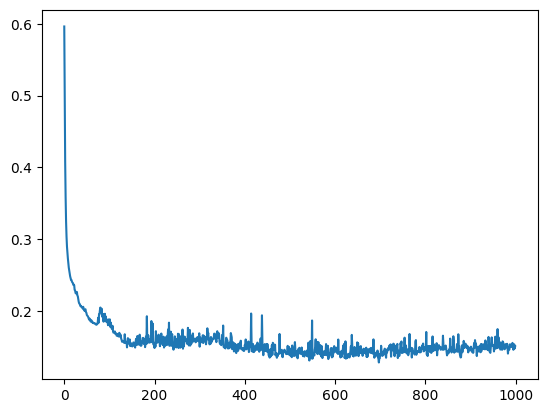

In [37]:
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
            
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    print(f"Epoch {epoch} MSE: {mse}")
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [34]:
model_name = 'prueba2'
# Save the model
torch.save(model, f'models/{model_name}.pt')   

In [ ]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=input_size),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

# Compile the network :
model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])

# Train the model
history = model.fit(X_train, y_train, epochs=500, batch_size=50, validation_data=(X_test, y_test))

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],  label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [ ]:
y_pred = model.predict(X_test).flatten()

plt.scatter(y_test, y_pred)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

In [19]:
print(y_train.shape)
# Change the shape of the y_train to a 1d array
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
print(y_train.shape)

(4000, 1)
(4000,)


In [20]:
X_train = X_train_raw
X_test = X_test_raw
print(X_train.shape)
print(X_test.shape)

(4000, 180)
(1001, 180)


In [21]:
model = RandomForestRegressor()
model.fit(X_train,y_train)

name = '3laps'

# Guarda el modelo
joblib.dump(model, f'models/RF_{name}.pkl')

# Get the mean absolute error on the validation data
y_pred = model.predict(X_test)
MAE = metrics.mean_absolute_error(y_test , y_pred)
MSE = metrics.mean_squared_error(y_test , y_pred)
print('Random forest validation MAE = ', MAE)
print('Random forest validation MSE = ', MSE)

Random forest validation MAE =  0.0824547981684442
Random forest validation MSE =  0.04309882070461062


In [23]:
# Save the current standard output
original_stdout = sys.stdout

In [26]:
model_name = '3lapsGridSearchCV'

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

with open(f'reports/{model_name}.txt', 'w') as f:
    with redirect_stdout(f):
        modelo_rf = RandomForestRegressor()

        grid_search = GridSearchCV(estimator=modelo_rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)

        print(f'Best parameters: {grid_search.best_params_}')
        print(f'Best estimator: {grid_search.best_estimator_}')

        # Save the model
        joblib.dump(grid_search, f'models/RF_{model_name}.pkl')

        # Test the model
        y_pred = grid_search.predict(X_test)

        print('================================================')
        print('================================================')
        MAE = metrics.mean_absolute_error(y_test , y_pred)
        MSE = metrics.mean_squared_error(y_test , y_pred)
        print('Random forest test MAE = ', MAE)
        print('Random forest test MSE = ', MSE)
        print('================================================')
        print('================================================')

# Restore the original standard output
sys.stdout = original_stdout

print("END OF THE CELL")

KeyboardInterrupt: 